In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression

from pyproj import Geod
import cartopy
import cartopy.crs as ccrs

## Initial Data Wrangling 🐴 ##

In [2]:
# ICE-6G_D Model goes back 122 Ka
ICE6G_D_122Ka = xr.open_dataset('~/VS Code/Zhong Geophysics/ICE_MODELS/ICE6G_122Ka/IceT.I6F_C.131QB_VM5a_1deg.nc')
# ICE-6G_C Model (Updated) Goes back 26 Ka
ICE6G_C_26Ka = xr.open_dataset('~/VS Code/Zhong Geophysics/ICE_MODELS/ICE6G_C_Combined/COMBINED_TIME_ICE-6G_C.nc')

In [3]:
ICE6G_D_122Ka.load()

<xarray.Dataset> Size: 32MB
Dimensions:  (Time: 122, Lat: 180, Lon: 360)
Coordinates:
  * Time     (Time) float32 488B 122.0 120.0 118.0 116.0 ... 0.75 0.5 0.25 0.0
  * Lat      (Lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * Lon      (Lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    stgit    (Time, Lat, Lon) float32 32MB 2.727e+03 2.727e+03 ... 0.0 0.0
Attributes:
    Model:            ICE-6G_D
    Acknowledgement:  Please cite both PAPER1 and PAPER2
    PAPER1:           Argus, D.F., Peltier, W.R., Drummond, R. and Moore, A.W...
    PAPER2:           Peltier, W.R., Argus, D.F. and Drummond, R. (2015). Spa...

In [4]:
ICE6G_C_26Ka.load()

<xarray.Dataset> Size: 75MB
Dimensions:    (Time: 48, Lat: 180, Lon: 360)
Coordinates:
  * Lat        (Lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * Lon        (Lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * Time       (Time) float64 384B 0.0 0.5 1.0 1.5 2.0 ... 23.0 24.0 25.0 26.0
Data variables:
    sftlf      (Time, Lat, Lon) float32 12MB 100.0 100.0 100.0 ... 0.0 0.0 0.0
    sftgif     (Time, Lat, Lon) float32 12MB 100.0 100.0 100.0 ... 0.0 0.0 0.0
    Topo_Diff  (Time, Lat, Lon) float32 12MB 0.0 0.0 0.0 ... 119.1 119.1 119.1
    Topo       (Time, Lat, Lon) float32 12MB 2.757e+03 2.758e+03 ... -4.08e+03
    orog       (Time, Lat, Lon) float32 12MB 2.757e+03 2.758e+03 ... 0.0 0.0
    stgit      (Time, Lat, Lon) float32 12MB 2.87e+03 2.87e+03 ... 0.0 0.0
Attributes:
    Model:            ICE=ICE-6G_C, Viscosity=VM5a
    Date:             November 14,2014
    Author:           W.R. Peltier, Dept of Physics, Univ of Toronto,Canada
    Acknowledgement:  Please cite both PAPER1[describes the new Antarctic com...
    PAPER1:           Argus, D.F., Peltier, W.R., Drummond, R. and Moore, A.W...
    PAPER2:           Peltier, W.R., Argus, D.F. and Drummond, R. - Space geo...

### Constants

In [5]:
# Approximate m SL/10^6 km^3 ice (meters of sea level rise per 10^6 cubic km of ice)
# From https://linkinghub.elsevier.com/retrieve/pii/S0277379118304074 (sourced from multiple estimates)
mSLRise = [2.485, 2.580, 2.519, 2.478, 2.577, 2.488, 2.466] # m/10^6 km^3

# Volumetric Mean Radius of Earth
R_E = 6371 #km

# Geoid Geometry, using WGS84 Coordinate System (CHECK??)
geod = Geod(ellps="WGS84")


### Methods

In [6]:
 def calc_IceVolume(ice_DS, time_bp):
    """ Estimate Total Volume of ice at a particular time before present.

    Args:
        year (float): thousands of years before present (e.g. input of 26.0 -> 26,000 years before present)
        ice_DS (Dataset): Dataset containing time evolution of ice on Earth
    """
    ice_atyear = ice_DS.sel(Time=time_bp, method="nearest")
    
    total_Volume = 0
    
    ## Need to Find Area of Each Lat/Lon Grid Space
    for lat in ice_atyear["Lat"].values:
        for lon in ice_atyear["Lon"].values:
            # Adjust for lat and lon centering at each 1x1 degree square (e.g. -45.5, 65.5 -> square
            # defined by Lon from -45 to -46 degrees and Lat from 65 to 66 degrees, convert to radians
            lat1 = (lat - 0.5)*np.pi/180 
            lat2 = (lat + 0.5)*np.pi/180
            lon1 = (lon - 0.5)*np.pi/180
            lon2 = (lon + 0.5)*np.pi/180
            
            # Calculate Area of Each square using Archimedes Principle: https://www.pmel.noaa.gov/maillists/tmap/ferret_users/fu_2004/msg00023.html
            area = (R_E**2)*abs(np.sin(lat1)-np.sin(lat2))*abs(lon1-lon2)
            
            # Find Volume using thickness of ice at this position (stgit in meters) and area
            volume = abs(area)*(ice_atyear.stgit.sel(Lon=lon, Lat=lat).values)/1000 # km^3
            total_Volume += volume
    
    return(total_Volume)
    
    

In [9]:
present_day_vol = calc_IceVolume(ICE6G_D_122Ka, 0.0)
for i in range(20,30):
    print(f"Time: {i} ka -> {calc_IceVolume(ICE6G_D_122Ka, i)-present_day_vol:f} km^3")

## Expected ~52*10^6 km^3 (Lambeck 2014, https://doi.org/10.1073/pnas.1411762111)

Time: 20 ka -> 44896544.0473 km^3
Time: 21 ka -> 45579753.5511 km^3
Time: 22 ka -> 46177983.4826 km^3
Time: 23 ka -> 47083681.1013 km^3
Time: 24 ka -> 48009715.1259 km^3
Time: 25 ka -> 49567208.9497 km^3
Time: 26 ka -> 51109024.1745 km^3
Time: 27 ka -> 47748715.7515 km^3
Time: 28 ka -> 42420916.8680 km^3
Time: 29 ka -> 36697316.3661 km^3


In [10]:
52**6

19770609664

In [ ]:
ICE6G_D_122Ka

<xarray.Dataset> Size: 32MB
Dimensions:  (Time: 122, Lat: 180, Lon: 360)
Coordinates:
  * Time     (Time) float32 488B 122.0 120.0 118.0 116.0 ... 0.75 0.5 0.25 0.0
  * Lat      (Lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * Lon      (Lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    stgit    (Time, Lat, Lon) float32 32MB 2.727e+03 2.727e+03 ... 0.0 0.0
Attributes:
    Model:            ICE-6G_D
    Acknowledgement:  Please cite both PAPER1 and PAPER2
    PAPER1:           Argus, D.F., Peltier, W.R., Drummond, R. and Moore, A.W...
    PAPER2:           Peltier, W.R., Argus, D.F. and Drummond, R. (2015). Spa...

## Testing Methods to Add Ice

In [ ]:
ICE6G_C_26Ka
ICE6G_D_122Ka

### Plotting 122 Ka Model

In [ ]:
def plot_ice_dist(model, time):
    ice_test = model.stgit

    lons = model.Lon
    lats = model.Lat
    lon, lat = np.meshgrid(lons, lats)

    useProj = ccrs.Mercator()
    fig = plt.figure(figsize=(9,6))

    ax = plt.axes(projection=useProj)
    ax.coastlines()
    ax.gridlines()

    ice_test.sel(Time = time, method = "nearest").plot(ax = ax, transform = ccrs.PlateCarree(), cmap="RdBu_r", cbar_kwargs={'shrink':0.4})


51109024.174540415

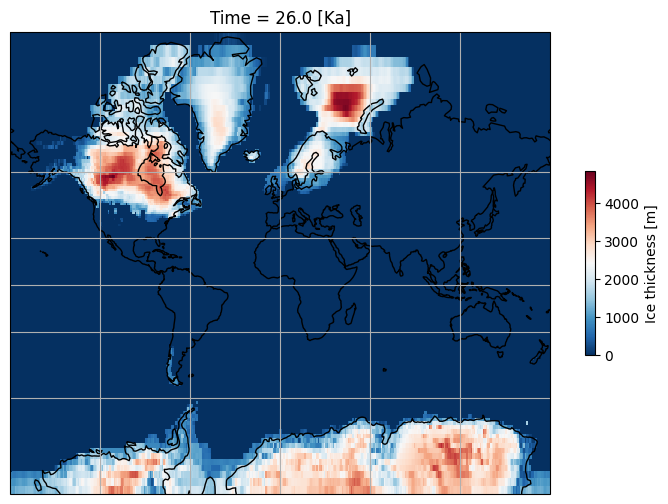

In [ ]:
## Original Model

time = 26.0 # Ka
model = ICE6G_D_122Ka

plot_ice_dist(model, time)
calc_IceVolume(ICE6G_D_122Ka, time) - present_day_vol


## Original Model, Parts Added, Final Plot -- a+b=c

#### Potential Linear Model

51912156.851572126

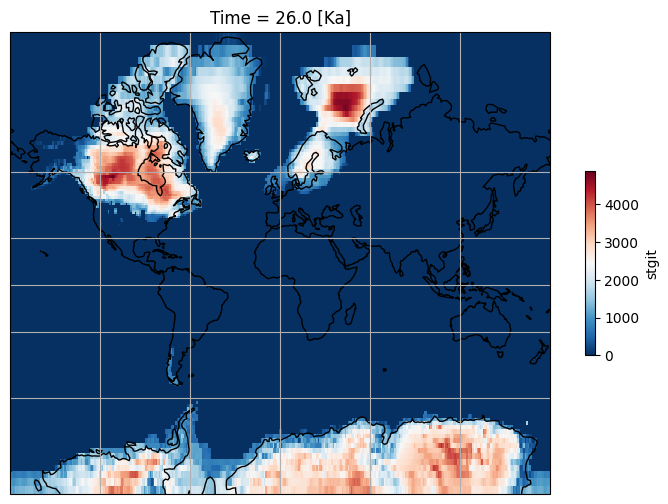

In [ ]:
# Modification Constants
m_const = 1.01
b_const = 0


Linear_Test = ICE6G_D_122Ka.copy()
Linear_Test['stgit'] = Linear_Test.stgit*m_const + b_const*(Linear_Test.stgit > 200)

plot_ice_dist(Linear_Test, time)
calc_IceVolume(Linear_Test, time) - present_day_vol